In [2]:
import sys
sys.path.append("..")
import numpy as np
import torch
import matplotlib.pyplot as plt
from seametrics.segmentation.pq import PanopticQuality

/home/franziskadenk/mambaforge/envs/mask2former/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
def show_masks(preds, targets):
    plt.subplots(figsize=(2, 2))
    plt.imshow(preds[:, :, 0])
    for i in range(preds.size(0)):
        for j in range(preds.size(1)):
            plt.text(i, j, preds[i, j, 1].item(), color="red", label="id")
    plt.title("Prediction")
    plt.show()

    plt.subplots(figsize=(2, 2))
    plt.imshow(targets[:, :, 0])
    for i in range(preds.size(0)):
        for j in range(preds.size(1)):
            plt.text(i, j, targets[i, j, 1].item(), color="red", label="id")
    plt.title("Targets")
    plt.show()

# Toy Example

### Perfect case

PQ score:  1.0


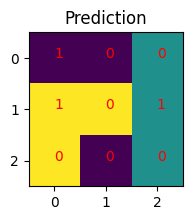

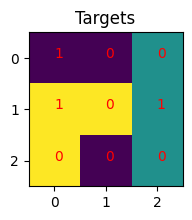

In [61]:
# preds and targets are of shape (batch_size, img_height, img_width, 2)
# the first element in the last dimension is the label category
# the second element in the last dimension is the instance id
# the instance id is ignored in the computation if the label category belongs to STUFF

preds = torch.tensor([[[0, 1], [0, 1], [1, 0]],
                      [[2, 0], [2, 0], [1, 0]],
                      [[2, 0], [0, 1], [1, 0]]])

targets = torch.tensor([[[0, 1], [0, 1], [1, 0]],
                        [[2, 0], [2, 0], [1, 0]],
                        [[2, 0], [0, 1], [1, 0]]])

pq = PanopticQuality(
    things={0, 1},
    stuffs={2}
)
score = pq.update_and_compute(preds, targets)
print("PQ score: ", score.item())
show_masks(preds, targets)

### Instance ID mismatch

If there is a wrong instance ID for a thing, the score is negatively influenced.

PQ score:  0.7999999999999999


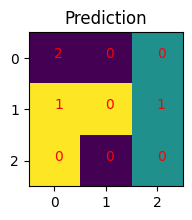

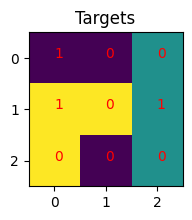

In [62]:
preds = torch.tensor([[[0, 2], [0, 1], [1, 0]], # note that the instance id at [0,0] is wrong
                      [[2, 0], [2, 0], [1, 0]],
                      [[2, 0], [0, 1], [1, 0]]])

targets = torch.tensor([[[0, 1], [0, 1], [1, 0]],
                        [[2, 0], [2, 0], [1, 0]],
                        [[2, 0], [0, 1], [1, 0]]])

pq = PanopticQuality(
    things={0, 1},
    stuffs={2}
)
score = pq.update_and_compute(preds, targets)
print("PQ score: ", score.item())
show_masks(preds, targets)

If there is a wrong instance ID for a stuff, the score doesn't change since stuff labels are merged to one instance per label (e.g. one sky).

PQ score:  1.0


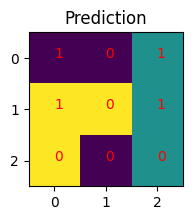

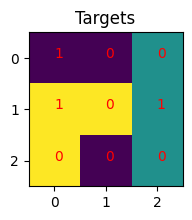

In [63]:
preds = torch.tensor([[[0, 1], [0, 1], [1, 0]], # note that the instance id at [0,0] is wrong
                      [[2, 0], [2, 0], [1, 0]],
                      [[2, 1], [0, 1], [1, 0]]])

targets = torch.tensor([[[0, 1], [0, 1], [1, 0]],
                        [[2, 0], [2, 0], [1, 0]],
                        [[2, 0], [0, 1], [1, 0]]])

pq = PanopticQuality(
    things={0, 1},
    stuffs={2}
)
score = pq.update_and_compute(preds, targets)
print("PQ score: ", score.item())
show_masks(preds, targets)

### Label mismatch

If the label category is wrong (which leads to a wrong instance id), then the score is also negatively impacted.

PQ score:  0.7857142857142857


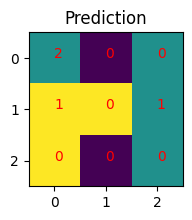

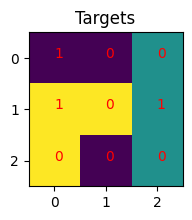

In [64]:
preds = torch.tensor([[[1, 2], [0, 1], [1, 0]], # note that the label at [0,0] is wrong
                      [[2, 0], [2, 0], [1, 0]],
                      [[2, 0], [0, 1], [1, 0]]])

targets = torch.tensor([[[0, 1], [0, 1], [1, 0]],
                        [[2, 0], [2, 0], [1, 0]],
                        [[2, 0], [0, 1], [1, 0]]])

pq = PanopticQuality(
    things={0, 1},
    stuffs={2}
)
score = pq.update_and_compute(preds, targets)
print("PQ score: ", score.item())
show_masks(preds, targets)

# SEA.AI Data

The following code shows how to calculate a PQ-score for SEA.AI data.

In [1]:
import os
os.environ["FIFTYONE_CONFIG_PATH"] = "/home/jigglypuff/.fiftyone/config.global_mongodb.json"

In [2]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
from seametrics.panoptic import PanopticQuality
from seametrics.panoptic.utils import payload_to_seg_metric
from seametrics.payload.processor import PayloadProcessor

/home/franziskadenk/mambaforge/envs/mask2former/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODEL_FIELD = ["maskformer-27k-100ep"]
TRIP = ["Trip_55_Seq_2"]
FRAME_IDX = 1
payload = PayloadProcessor("SAILING_PANOPTIC_DATASET_QA",
                        gt_field="ground_truth_det",
                        models=MODEL_FIELD,
                        sequence_list=TRIP,
                        excluded_classes=[""]).payload

Processing sequences: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Predicted masks maskformer-27k-100ep:


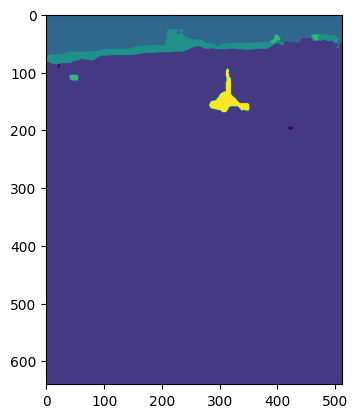

Ground truth masks


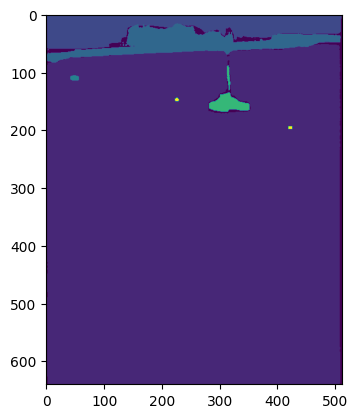

In [4]:
pred, gt, label2id = payload_to_seg_metric(payload, MODEL_FIELD[0])
print(f"Predicted masks {MODEL_FIELD[0]}:")
plt.imshow(pred[FRAME_IDX][:, : , 0]/len(pred[1]*255))
plt.show()
print("Ground truth masks")
plt.imshow(gt[FRAME_IDX][:, : , 0]/len(gt[1])*255)
plt.show()

In [5]:
DEFAULT_LABEL2ID = {'WATER': 0,
                    'SKY': 1,
                    'LAND': 2,
                    'MOTORBOAT': 3,
                    'FAR_AWAY_OBJECT': 4,
                    'SAILING_BOAT_WITH_CLOSED_SAILS': 5,
                    'SHIP': 6,
                    'WATERCRAFT': 7,
                    'SPHERICAL_BUOY': 8,
                    'CONSTRUCTION': 9,
                    'FLOTSAM': 10,
                    'SAILING_BOAT_WITH_OPEN_SAILS': 11,
                    'CONTAINER': 12,
                    'PILLAR_BUOY': 13,
                    'AERIAL_ANIMAL': 14,
                    'HUMAN_IN_WATER': 15,
                    'OWN_BOAT': 16,
                    'WOODEN_LOG': 17,
                    'MARITIME_ANIMAL': 18}

STUFF = ["WATER", "SKY", "LAND", "CONSTRUCTION", "ICE", "OWN_BOAT"]

In [6]:
pred_masks, gt_masks, label2id = payload_to_seg_metric(payload, MODEL_FIELD[0], label2id=DEFAULT_LABEL2ID)
pq = PanopticQuality(
    things=set([label2id[label] for label in DEFAULT_LABEL2ID.keys() if label not in STUFF]),
    stuffs=set([label2id[label] for label in DEFAULT_LABEL2ID.keys() if label in STUFF]),
    areas=[(0,2000), (2000,1e8), (0, 1e8)]
)
pq.update(pred_masks[FRAME_IDX][np.newaxis, :,:], gt_masks[FRAME_IDX][np.newaxis, :,:])

Added data ...


We can access the inner attributes of the PQ calculation. But this can be only done before calling `metric.compute()` because this will reset all the internal states to 0.

In [7]:
tp = pq.metric.true_positives
tp

tensor([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]],
       device='cuda:0', dtype=torch.int32)

In [8]:
fn = pq.metric.false_negatives
fn

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]],
       device='cuda:0', dtype=torch.int32)

In [9]:
fp = pq.metric.false_positives
fp

tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]],
       device='cuda:0', dtype=torch.int32)

In [10]:
iou = pq.metric.iou_sum 
iou

tensor([[0.7285, 0.0000, 0.8217, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9922, 0.7854, 0.0000, 0.0000,
         0.0000],
        [0.7285, 0.0000, 0.8217, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9922, 0.7854, 0.0000, 0.0000,
         0.0000]], device='cuda:0', dtype=torch.float64)

Finally, we can compute the result for the single frame.

In [11]:
pq_score, sq, rq = pq.compute()

Start computing ...
Finished!


In [12]:
pq_score # number cols= number class (first sorted things, then sorted stuffs), number rows = defined area ranges as specified when instance of metric was created

tensor([[0.3642, 0.0000, 0.8217, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9922, 0.7854, 0.0000, 0.0000,
         0.0000],
        [0.3642, 0.0000, 0.8217, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9922, 0.7854, 0.0000, 0.0000,
         0.0000]], device='cuda:0', dtype=torch.float64)

In [13]:
sq

tensor([[0.7285, 0.0000, 0.8217, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9922, 0.7854, 0.0000, 0.0000,
         0.0000],
        [0.7285, 0.0000, 0.8217, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9922, 0.7854, 0.0000, 0.0000,
         0.0000]], device='cuda:0', dtype=torch.float64)

In [14]:
rq

tensor([[0.5000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
         0.0000],
        [0.5000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
         0.0000]], device='cuda:0', dtype=torch.float64)

We can also calculate the score over the whole sequence. Instead of calling `metric.update(preds, targets)` and `metric.compute()`, we do this together with `metric.update_and_compute(preds, targets)`.

In [15]:
pq_score, sq, rq = pq.update_and_compute(pred_masks, gt_masks) 

Added data ...
Start computing ...
Finished!


Finally, we can adapt if we want the result to be aggregated over classes and/or over areas.

In [16]:
pq = PanopticQuality(
    things=set([label2id[label] for label in DEFAULT_LABEL2ID.keys() if label not in STUFF]),
    stuffs=set([label2id[label] for label in DEFAULT_LABEL2ID.keys() if label in STUFF]),
    areas=[(0,2000), (2000,1e8), (0, 1e8)],
    return_sq_and_rq=False
)
pq_score = pq.update_and_compute(pred_masks, gt_masks) 
pq_score

In [ ]:
pq = PanopticQuality(
    things=set([label2id[label] for label in DEFAULT_LABEL2ID.keys() if label not in STUFF]),
    stuffs=set([label2id[label] for label in DEFAULT_LABEL2ID.keys() if label in STUFF]),
    areas=[(0,2000), (2000,1e8), (0, 1e8)],
    return_sq_and_rq=False,
    return_per_class=False
)
pq.update(pred_masks, gt_masks) 
pq.compute()

Added data ...
Start computing ...
Finished!


tensor([0.0761, 0.4396, 0.2552], device='cuda:0', dtype=torch.float64)